In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#0.1 Single Agent

In [39]:
import numpy as np
import itertools as its
import random as rn
import pandas as pd
from itertools import product
from tqdm import tqdm
ind = 0
dygame = np.zeros([2,2,2,2,2]) #st,at1, at2,st+1, zt+1
for st, at1, at2 in its.product(range(2),range(2),range(2)):
  ind = ind + 1
  rn.seed(ind)
  prob = rn.choices(np.arange(11), weights=None, cum_weights=None, k=4)
  dygame[st,at1,at2,:,:] = np.reshape(prob/np.sum(prob),[2,2])

np.random.seed(0)
theta2 = np.random.uniform(1,5,8)
#print(theta)
theta2 = np.reshape(pd.Series(theta2).round(2).to_numpy(),[2,2,2])
#print(theta2)

def rw(s,a1,a2,theta2=theta2): # sc in {0,1}, a1,a2 in {0,1}
  theta2 = np.reshape(theta2,[2,2,2])
  return theta2[s,a1,a2]

def siglam(z,x,a1,a2,theta1=dygame):
  theta1 = np.reshape(theta1,[2,2,2,2,2])

  if np.shape(x) == ():
    lambd = theta1[:,a1,a2,:,z].T.dot([x,1-x])
    sigma = np.sum(lambd)
    return lambd[0]/sigma, sigma

  else:
    m = np.transpose(theta1[:,a1,a2,:,z],axes=(0,1,3,2))
    n = np.stack([x,1-x],axis=2).reshape([m.shape[0],m.shape[1],2,1])
    lambd = np.matmul(m, n)
    sigma = np.sum(lambd,axis=(2,3))
    return lambd[:,:,0,0]/sigma,sigma
#print(Q1)

In [40]:
from scipy import linalg, optimize

pi1 = lambda x : 0.5 # for action = 0, agent 1
pi2 = lambda x : 0.5
epsoide = 20
Sample = 200
subSample = 250
T = 150
gamma = 0.5772
beta = 0.9
Q1 = np.ones([epsoide,Sample,2])
Q2 = np.ones([epsoide,Sample,2])

xx = np.ones([epsoide,Sample])
policy1 = np.ones([epsoide,Sample,2])
policy2 = np.ones([epsoide,Sample,2])

Q_curvefit = True

if Q_curvefit:
  slop1_Q = np.ones([epsoide,2,3])
  slop2_Q = np.ones([epsoide,2,3])
else:
  slop1_pi = np.ones([epsoide,3])
  slop2_pi = np.ones([epsoide,3])



def f_1(x, A, B,C):
    return A * x**2 + B *x +C

for i in tqdm(range(epsoide)):
  r1 = np.zeros([Sample,subSample,T])
  r2 = np.zeros([Sample,subSample,T])
  a1 = np.concatenate([np.zeros([Sample,int(subSample/2),T],dtype=int),np.ones([Sample,int(subSample/2),T],dtype=int)],axis=1)
  a2 = np.concatenate([np.zeros([Sample,int(subSample/2),T],dtype=int),np.ones([Sample,int(subSample/2),T],dtype=int)],axis=1)
  st = np.zeros([Sample,subSample,T+1],dtype = int)
  zt = np.zeros([Sample,subSample,T],dtype = int)
  belief = np.zeros([Sample,subSample,T+1])

  belief[:,:,0] = np.kron(np.random.uniform(size=Sample),np.ones(subSample)).reshape([Sample,subSample])#beta.stats(2,3)
  st[:,:,0] = np.zeros([Sample,subSample],dtype= int)#np.random.binomial(1,0.5,size = Sample)

  #t=0
  #if t==0:
  for t in range(T):
    if t!=0:
      a1[:,:,t] = np.intc(np.random.uniform(size = [Sample,subSample]) >= pi1(belief[:,:,t-1]))
      a2[:,:,t] = np.intc(np.random.uniform(size = [Sample,subSample]) >= pi2(belief[:,:,t-1]))
      # a1[:,:,t] = np.random.binomial(1,1-pi1,size = [Sample,subSample])
      # a2[:,:,t] = np.random.binomial(1,1-pi2,size = [Sample,subSample])
    
    prob3 = dygame[st[:,:,t], a1[:,:,t],a2[:,:,t],:,:]#st,at1, at2,st+1, zt+1

    prob4 = prob3.reshape([Sample,subSample,4]).dot(np.triu(np.ones(4)))

    haha1 = np.random.uniform(size=[Sample,subSample,1]).dot(np.ones([1,4]))
    haha2 = np.sum(np.intc(haha1-prob4 >=0),axis=2)
    st[:,:,t+1], zt[:,:,t] = (haha2)//2,haha2%2


    belief[:,:,t+1],_ = siglam(zt[:,:,t],belief[:,:,t],a1[:,:,t],a2[:,:,t])

    pi1_t = pi1(belief[:,:,t])
    pi2_t = pi2(belief[:,:,t])


    r1[:,:,t] = (belief[:,:,t] *(pi2_t*rw(0,a1[:,:,t],0) + (1-pi2_t)*rw(0,a1[:,:,t],1)) +\
                      (1-belief[:,:,t]) *(pi2_t*rw(1,a1[:,:,t],0) + (1-pi2_t)*rw(1,a1[:,:,t],1)) +\
                      (t!=0)*(gamma - np.log((a1[:,:,t]==0)*pi1_t+(a1[:,:,t]==1)*(1-pi1_t)))\
                      ) * (beta**t)
    r2[:,:,t] = (belief[:,:,t] *(pi1_t*rw(0,0,a2[:,:,t])+(1-pi1_t)*rw(0,1,a2[:,:,t])) +\
                      (1-belief[:,:,t])*(pi1_t*rw(1,0,a2[:,:,t])+(1-pi1_t)*rw(1,1,a2[:,:,t]))  +\
                      (t!=0)*(gamma - np.log((a2[:,:,t]==0)*pi2_t+(a2[:,:,t]==1)*(1-pi2_t)))\
                      ) * (beta**t)

  Q1[i,:,0] = np.average(np.sum(r1[:,0:int(subSample/2),:],axis=2),axis=1)   
  Q1[i,:,1] = np.average(np.sum(r1[:,int(subSample/2):subSample,:],axis=2),axis=1)   
  Q2[i,:,0] = np.average(np.sum(r2[:,0:int(subSample/2),:],axis=2),axis=1)   
  Q2[i,:,1] = np.average(np.sum(r2[:,int(subSample/2):subSample,:],axis=2),axis=1)

  xx[i,:] = belief[:,0,0]
  policy1[i,:,0] = np.exp(Q1[i,:,0]-Q1[i,:,1])/(1+np.exp(Q1[0,:,0]-Q1[0,:,1])) # action = 0
  policy1[i,:,1] = 1-policy1[i,:,0]                                            # action = 1
  policy2[i,:,0] = np.exp(Q2[i,:,0]-Q2[i,:,1])/(1+np.exp(Q2[0,:,0]-Q2[0,:,1])) # action = 0
  policy2[i,:,1] = 1-policy2[i,:,0]                                            # action = 1

  if Q_curvefit:
    fitfunc11 = optimize.curve_fit(f_1,xx[i,:],Q1[i,:,0])
    fitfunc12 = optimize.curve_fit(f_1,xx[i,:],Q1[i,:,1])

    fitfunc21 = optimize.curve_fit(f_1,xx[i,:],Q2[i,:,0])
    fitfunc22 = optimize.curve_fit(f_1,xx[i,:],Q2[i,:,1])

    pi1 = lambda x: np.exp(f_1(x,fitfunc11[0][0],fitfunc11[0][1],fitfunc11[0][2])-\
                          f_1(x,fitfunc12[0][0],fitfunc12[0][1],fitfunc12[0][2]))/\
                          (1+np.exp(f_1(x,fitfunc11[0][0],fitfunc11[0][1],fitfunc11[0][2])-\
                          f_1(x,fitfunc12[0][0],fitfunc12[0][1],fitfunc12[0][2])))
    pi2 = lambda x: np.exp(f_1(x,fitfunc21[0][0],fitfunc21[0][1],fitfunc21[0][2])-\
                          f_1(x,fitfunc22[0][0],fitfunc22[0][1],fitfunc22[0][2]))/\
                          (1+np.exp(f_1(x,fitfunc21[0][0],fitfunc21[0][1],fitfunc21[0][2])-\
                          f_1(x,fitfunc22[0][0],fitfunc22[0][1],fitfunc22[0][2])))

    slop1_Q[i,0,:] = fitfunc11[0]
    slop1_Q[i,1,:] = fitfunc12[0]

    slop2_Q[i,0,:] = fitfunc21[0]
    slop2_Q[i,1,:] = fitfunc22[0]
  
  else:

    fitfunc1 = optimize.curve_fit(f_1,xx[i,:],policy1[i,:,0])
    fitfunc2 = optimize.curve_fit(f_1,xx[i,:],policy2[i,:,0])
    pi1 = lambda x: f_1(x,fitfunc1[0][0],fitfunc1[0][1],fitfunc1[0][2])
    pi2 = lambda x: f_1(x,fitfunc2[0][0],fitfunc2[0][1],fitfunc2[0][2])

    slop1_pi[i,:] = fitfunc1[0]
    slop2_pi[i,:] = fitfunc2[0]








100%|██████████| 20/20 [02:37<00:00,  7.88s/it]


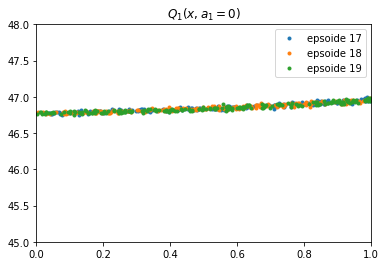

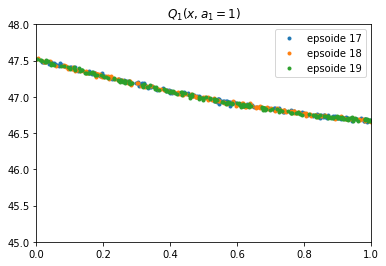

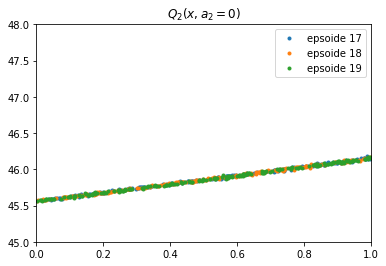

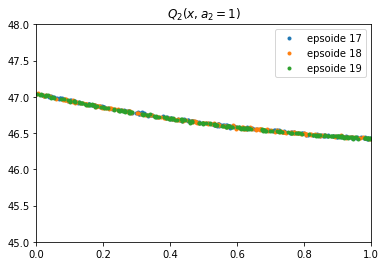

In [41]:
import matplotlib.pyplot as plt

line_num = 3
plot_list = np.arange(line_num)+epsoide-line_num

for i in plot_list:#range(epsoide):
  plt.plot(xx[i,:],Q1[i,:,0],'.',label = 'epsoide {}'.format(i))
plt.xlim(0,1)
plt.ylim(45,48)
plt.title(r'$Q_1(x,a_1=0)$')
plt.legend()
plt.show()
  # plt.plot(xx[i,:],Q1[i,:,1],'.')
for i in plot_list:#range(epsoide):
  plt.plot(xx[i,:],Q1[i,:,1],'.',label = 'epsoide {}'.format(i))
plt.xlim(0,1)
plt.ylim(45,48)
plt.title(r'$Q_1(x,a_1=1)$')
plt.legend()
plt.show()

for i in plot_list:#range(epsoide):
  plt.plot(xx[i,:],Q2[i,:,0],'.',label = 'epsoide {}'.format(i))
plt.xlim(0,1)
plt.ylim(45,48)
plt.title(r'$Q_2(x,a_2=0)$')
plt.legend()
plt.show()
  # plt.plot(xx[i,:],Q1[i,:,1],'.')
for i in plot_list:#range(epsoide):
  plt.plot(xx[i,:],Q2[i,:,1],'.',label = 'epsoide {}'.format(i))
plt.xlim(0,1)
plt.ylim(45,48)
plt.title(r'$Q_2(x,a_2=1)$')
plt.legend()
plt.show()

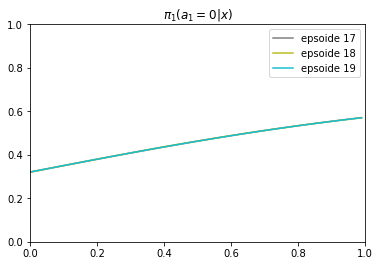

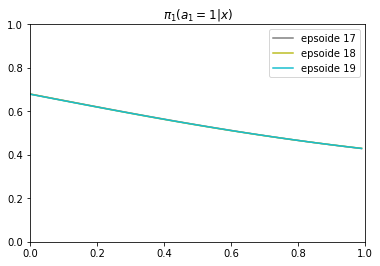

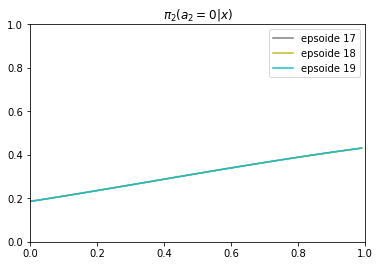

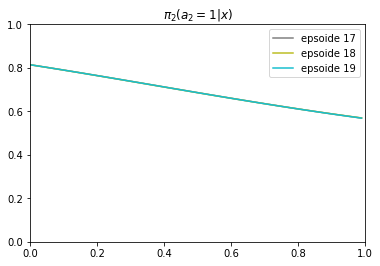

In [42]:
import matplotlib.pyplot as plt
fit_num = 100

x_fit = np.arange(fit_num)/fit_num

if Q_curvefit:
  fuc1 = lambda x,slop1_Q: np.exp(f_1(x,slop1_Q[0,0],slop1_Q[0,1],slop1_Q[0,2])-\
                        f_1(x,slop1_Q[1,0],slop1_Q[1,1],slop1_Q[1,2]))/\
                        (1+np.exp(f_1(x,slop1_Q[0,0],slop1_Q[0,1],slop1_Q[0,2])-\
                        f_1(x,slop1_Q[1,0],slop1_Q[1,1],slop1_Q[1,2])))
  fuc2 = lambda x, slop2_Q: np.exp(f_1(x,slop2_Q[0,0],slop2_Q[0,1],slop2_Q[0,2])-\
                        f_1(x,slop2_Q[1,0],slop2_Q[1,1],slop2_Q[1,2]))/\
                        (1+np.exp(f_1(x,slop2_Q[0,0],slop2_Q[0,1],slop2_Q[0,2])-\
                        f_1(x,slop2_Q[1,0],slop2_Q[1,1],slop2_Q[1,2])))


for i in plot_list:#range(epsoide):
  #plt.plot(xx[i,:],policy1[i,:,0],'.',label = 'epsoide {}'.format(i),color = 'C{}'.format(i))
  if Q_curvefit:

    plt.plot(x_fit,fuc1(x_fit,slop1_Q[i,:,:]),'-',color = 'C{}'.format(i),label = 'epsoide {}'.format(i))
  else:
    plt.plot(x_fit,f_1(x_fit,slop1_pi[i,0],slop1_pi[i,1],slop1_pi[i,2]),'-',color = 'C{}'.format(i),label = 'epsoide {}'.format(i))
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(r'$\pi_1(a_1=0|x)$')
plt.legend()
plt.show()

for i in plot_list:#range(epsoide):
  #plt.plot(xx[i,:],policy1[i,:,1],'.',label = 'epsoide {}'.format(i),color = 'C{}'.format(i))
  if Q_curvefit:
    plt.plot(x_fit,1-fuc1(x_fit,slop1_Q[i,:,:]),'-',color = 'C{}'.format(i),label = 'epsoide {}'.format(i))
  else:
    plt.plot(x_fit,1-f_1(x_fit,slop1_pi[i,0],slop1_pi[i,1],slop1_pi[i,2]),'-',color = 'C{}'.format(i),label = 'epsoide {}'.format(i))
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(r'$\pi_1(a_1=1|x)$')
plt.legend()
plt.show()

for i in plot_list:#range(epsoide):
  #plt.plot(xx[i,:],policy2[i,:,0],'.',label = 'epsoide {}'.format(i),color = 'C{}'.format(i))
  if Q_curvefit:
    plt.plot(x_fit,fuc2(x_fit,slop2_Q[i,:,:]),'-',color = 'C{}'.format(i),label = 'epsoide {}'.format(i))
  else:
    plt.plot(x_fit,f_1(x_fit,slop2_pi[i,0],slop2_pi[i,1],slop2_pi[i,2]),'-',color = 'C{}'.format(i),label = 'epsoide {}'.format(i))
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(r'$\pi_2(a_2=0|x)$')
plt.legend()
plt.show()

for i in plot_list:#range(epsoide):
  if Q_curvefit:
    plt.plot(x_fit,1-fuc2(x_fit,slop2_Q[i,:,:]),'-',color = 'C{}'.format(i),label = 'epsoide {}'.format(i))
  else:
  #plt.plot(xx[i,:],policy2[i,:,1],'.',label = 'epsoide {}'.format(i),color = 'C{}'.format(i))
    plt.plot(x_fit,1-f_1(x_fit,slop2_pi[i,0],slop2_pi[i,1],slop2_pi[i,2]),'-',color = 'C{}'.format(i),label = 'epsoide {}'.format(i))
plt.xlim(0,1)
plt.ylim(0,1)
plt.title(r'$\pi_2(a_2=1|x)$')
plt.legend()
plt.show()


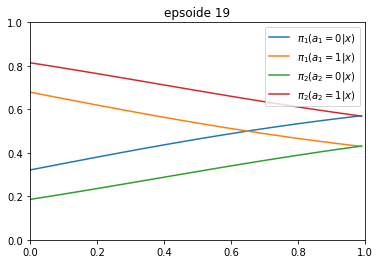

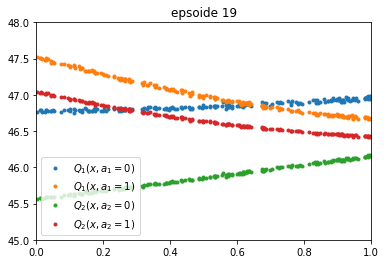

In [43]:
import matplotlib.pyplot as plt
if Q_curvefit:
  plt.plot(x_fit,fuc1(x_fit,slop1_Q[epsoide-1,:,:]),'-',label = r'$\pi_1(a_1=0|x)$')
  plt.plot(x_fit,1-fuc1(x_fit,slop1_Q[epsoide-1,:,:]),'-',label = r'$\pi_1(a_1=1|x)$')
  plt.plot(x_fit,fuc2(x_fit,slop2_Q[epsoide-1,:,:]),'-',label = r'$\pi_2(a_2=0|x)$')
  plt.plot(x_fit,1-fuc2(x_fit,slop2_Q[epsoide-1,:,:]),'-',label = r'$\pi_2(a_2=1|x)$')
else:

  plt.plot(x_fit,f_1(x_fit,slop1_pi[epsoide-1,0],slop1_pi[epsoide-1,1],slop1_pi[epsoide-1,2]),'-',label = r'$\pi_1(a_1=0|x)$')
  plt.plot(x_fit,1-f_1(x_fit,slop1_pi[epsoide-1,0],slop1_pi[epsoide-1,1],slop1_pi[epsoide-1,2]),'-',label = r'$\pi_1(a_1=1|x)$')
  plt.plot(x_fit,f_1(x_fit,slop2_pi[epsoide-1,0],slop2_pi[epsoide-1,1],slop2_pi[epsoide-1,2]),'-',label = r'$\pi_2(a_2=0|x)$')
  plt.plot(x_fit,1-f_1(x_fit,slop2_pi[epsoide-1,0],slop2_pi[epsoide-1,1],slop2_pi[epsoide-1,2]),'-',label = r'$\pi_2(a_2=1|x)$')
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.title('epsoide {}'.format(epsoide-1))
plt.show()

plt.plot(xx[epsoide-1,:],Q1[epsoide-1,:,0],'.',label = r'$Q_1(x,a_1=0)$')
plt.plot(xx[epsoide-1,:],Q1[epsoide-1,:,1],'.',label = r'$Q_1(x,a_1=1)$')
plt.plot(xx[epsoide-1,:],Q2[epsoide-1,:,0],'.',label = r'$Q_2(x,a_2=0)$')
plt.plot(xx[epsoide-1,:],Q2[epsoide-1,:,1],'.',label = r'$Q_2(x,a_2=1)$')
plt.xlim(0,1)
plt.ylim(45,48)
plt.legend()
plt.title('epsoide {}'.format(epsoide-1))

plt.show()

# Original without Sa
(Recovering for dynamics still has problems)

In [ ]:
pip install pwlf

  Created wheel for pwlf: filename=pwlf-2.0.4-cp37-none-any.whl size=16156 sha256=66c7ba0d6794289f0e5b4c74c00dea219730dea1e179966ceff2f1fb67a5f823
  Stored in directory: /root/.cache/pip/wheels/aa/b4/ef/2cb67a24a71a0d9dd93a5ba02f46106e9fa34dd2e3d9d8b4a0
  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp37-none-any.whl size=18184 sha256=de879d7c2a5a38b8db69344a08e59d1bb1754489476da43441f270b523660888
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pwlf pyDOE


[-1.11022302e-16  1.11022302e-16  4.44089210e-16  1.11022302e-16
 -2.22044605e-16  2.22044605e-16 -3.88578059e-16 -4.44089210e-16
 -6.66133815e-16 -2.22044605e-16]


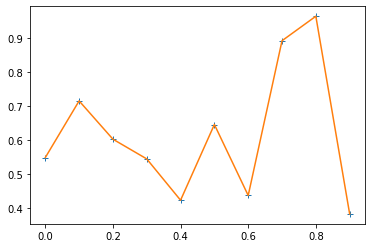

In [ ]:
import numpy as np
import pwlf
np.random.seed(0)
y = np.random.uniform(size=10)
x= np.arange(10)/10

import matplotlib.pyplot as plt

plt.plot(x,y,'+')


myPWLF = pwlf.PiecewiseLinFit(x,y)

#   fit the data for four line segments
myPWLF.fit(9)


#print(res)

print(myPWLF.predict(x)-y)
plt.plot(x,myPWLF.predict(x),'-')


In [44]:
import numpy as np
import random as rn
import itertools as its
from sklearn.preprocessing import normalize
from tqdm import tqdm
# import pwlf
from scipy.special import logsumexp
class DataGeneration(object):
    def __init__(self, theta ,N,T,x0_dim):#,belief_data,belief_recover):
      self.reward = theta #s a1 a2
      self.x0_dim = x0_dim

      self.dygame = np.zeros([2,2,2,2,2]) #st,at1, at2,st+1, zt+1
      ind = 0
      for st, at1, at2 in its.product(range(2),range(2),range(2)):
        ind = ind + 1
        rn.seed(ind)
        prob = rn.choices(np.arange(11), weights=None, cum_weights=None, k=4)
        self.dygame[st,at1,at2,:,:] = np.reshape(prob/np.sum(prob),[2,2])
      
      self.N = N
      self.T = T
      
      self.gamma = 0.5772
      self.beta = 0.9

      # self.belief_data = belief_data
      # self.belief_recover = belief_recover
      #self.blief = 61
      # self.iniccp_data = np.ones([self.belief_data,2])/2#np.vstack([np.ones(self.blief),np.zeros(self.blief)]).T
      # self.iniccp_recover = np.ones([self.belief_recover,2])/2#np.vstack([np.ones(self.blief),np.zeros(self.blief)]).T

    def rw(self,s,a1,a2,theta2): # sc in {0,1}, a1,a2 in {0,1}
      theta2 = np.reshape(theta2,[2,2,2])
      return theta2[s,a1,a2]

    def siglam(self,z,x,a1,a2,theta1):
      theta1 = np.reshape(theta1,[2,2,2,2,2])
      lambd = theta1[:,a1,a2,:,z].T.dot([x,1-x])
      sigma = np.sum(lambd)
      return lambd[0]/sigma, sigma

    def PartCCP(self,ccp,ccpc,theta2,theta1,thread1,blief, maxiter = 100):
      # if status ==0:
      #   blief = self.belief_data
      # else:
      #   blief = self.belief_recover
      Q = 45*np.ones([blief,2])
      #print(maxiter)    
      for j in range(maxiter):
        Q_old = Q.copy()
        #V = self.gamma + logsumexp(Q,axis=1)#np.log(np.sum(np.exp(Q),axis=1))
        #print(j,V)
        for indx, inda in its.product(self.x,range(2)):#x,a_i
          
          l = np.zeros([2,2])#z,a_{-i}
          s = np.zeros([2,2])#z,a_{-i}
          Qa0_tep = np.zeros([2,2])
          Qa1_tep = np.zeros([2,2])
          for indl, inds in its.product(range(2),range(2)): #z , a_{-i}
            
            l[indl,inds],s[indl,inds] = (ccp==2)*self.siglam(indl,indx,inds,inda,theta1)+\
                                        (ccp==1)*self.siglam(indl,indx,inda,inds,theta1) #z ,x, a1,a2
            fl = int(np.floor(l[indl,inds] * (blief-1)))
            if fl == blief-1: #z,a_{-i}
              Qa0_tep[indl,inds] = Q_old[fl,0]
              Qa1_tep[indl,inds] = Q_old[fl,1]
              #V_tep[indl,inds] = V[fl]
            else:
              Qa0_tep[indl,inds] = Q_old[fl,0] *(1 + fl -l[indl,inds]*(blief-1)) + Q_old[fl+1,0]*(l[indl,inds]*(blief-1) - fl)
              Qa1_tep[indl,inds] = Q_old[fl,1] *(1 + fl -l[indl,inds]*(blief-1)) + Q_old[fl+1,1]*(l[indl,inds]*(blief-1) - fl)

              #V_tep[indl,inds] = V[fl] * (1 + fl -l[indl,inds]*(blief-1))  + V[fl+1]*(l[indl,inds]*(blief-1) - fl) 
          #V_tep = V_tep * s
          V_tep = self.gamma + np.log(np.exp(Qa0_tep)+np.exp(Qa1_tep))
          V_tep = V_tep*s

          ind = int(indx *(blief-1))
                          
          Q[ind,inda] = (ccp==2)*(ccpc[ind,0] * (indx* self.rw(0,0,inda,theta2) + (1-indx) * self.rw(1,0,inda,theta2) + self.beta * np.sum(V_tep[:,0])) +\
                                  ccpc[ind,1] * (indx* self.rw(0,1,inda,theta2) + (1-indx) * self.rw(1,1,inda,theta2) + self.beta * np.sum(V_tep[:,1]))) +\
                        (ccp==1)*(ccpc[ind,0] * (indx* self.rw(0,inda,0,theta2) + (1-indx) * self.rw(1,inda,0,theta2) + self.beta * np.sum(V_tep[:,0])) +\
                                  ccpc[ind,1] * (indx* self.rw(0,inda,1,theta2) + (1-indx) * self.rw(1,inda,1,theta2) + self.beta * np.sum(V_tep[:,1])))
          #print(self.x[ind],ind,inda,Q[ind,inda])
        #print('Q',j,np.max(Q),np.max(Q_old),np.max(np.abs(Q-Q_old)))
        if np.max(np.abs(Q-Q_old))<=thread1:
          #print('Q',j,np.max(Q),np.max(Q_old),np.max(np.abs(Q-Q_old)))
          break
      ccpcc = Q.copy()#normalize(np.exp(Q), norm='l1',axis=1)#np.exp(Q1)/(np.sum(np.exp(Q1),axis=1)) 
      ccpcc[:,0] = np.exp([Q[:,0]-Q[:,1]])/(np.exp([Q[:,0]-Q[:,1]]) +1 )
      ccpcc[:,1] = 1-ccpcc[:,0]
      return ccpcc,Q

    def PerfectMarkov(self,ccp,iniCCP1,theta2,theta1,blief,maxiter = 100,thread1 = 1e-5,thread2 = 1e-4):
      # if status ==0:
      #   blief = self.belief_data
      # else:
      #   blief = self.belief_recover     
      self.x = np.linspace(0,1,blief)     
      ccp1 = iniCCP1
      ccp2 = iniCCP1
      Q1_old = 45*np.ones([blief,2])
      #for i in tqdm(range(maxiter)):
      for i in range(maxiter):

        ccp1_old = ccp1.copy()
        ccp2_old = ccp2.copy()
        if ccp==1:
          ccp2,Q2 = self.PartCCP(ccp+1,ccp1_old,theta2,theta1,thread1,blief)
          ccp1,Q1 = self.PartCCP(ccp,ccp2,theta2,theta1,thread1,blief)
        else:
          ccp1,Q1 = self.PartCCP(ccp-1,ccp2_old,theta2,theta1,thread1,blief)
          ccp2,Q2 = self.PartCCP(ccp,ccp1,theta2,theta1,thread1,blief)

        # if np.max(np.abs((Q1_old-Q1))<=thread2):
        #print(i,'pi',np.max(ccp1),np.max(ccp2),np.max(np.abs(ccp1-ccp1_old)),np.max(np.abs(ccp2-ccp2_old)))
        #print(i,'Q',np.max(Q1),np.max(Q1_old),np.max(np.abs(Q1-Q1_old)))

        if np.max(np.abs(ccp1-ccp1_old))<=thread2 and np.max(np.abs(ccp2-ccp2_old))<=thread2:
          #print(i,ccp1,ccp2)
          #print(i,np.max(ccp1),np.max(ccp2),np.max(np.abs(ccp1-ccp1_old)),np.max(np.abs(ccp2-ccp2_old)))
          break
        Q1_old= Q1.copy()
        #print(i,ccp1,ccp2)  
        #print(i,np.max(ccp1),np.max(ccp2),np.max(np.abs(ccp1-ccp1_old)),np.max(np.abs(ccp2-ccp2_old)))
      if i == maxiter -1:
        print('fail to converge')
      return ccp1, ccp2, [Q1,Q2]#i


    # def simulation(self,blief):
    #   #blief = self.belief_data
    #   iniccp_data = np.ones([blief,2])/2#np.vstack([np.ones(self.blief),np.zeros(self.blief)]).T

    #   ccp1, ccp2,_ = self.PerfectMarkov(1,iniccp_data,self.reward,self.dygame,blief)

    #   self.st = np.zeros([self.N,self.T+1],dtype = int)
    #   self.zt = np.zeros([self.N,self.T],dtype = int)
    #   self.a1t = np.zeros([self.N,self.T],dtype = int)
    #   self.a2t = np.zeros([self.N,self.T],dtype = int)
    #   self.belief = 1/2 * np.ones([self.N,self.T+1])
    #   self.belief[:,0] = np.kron(np.ones(int(self.N/self.x0_dim)),np.linspace(0,1,num = self.x0_dim))

    #   rn.seed(0)
    #   self.st[:,0] = rn.choices([0,1],[1/2,1/2], k = self.N)

    #   for ss in range(self.N):
    #     for t in range(self.T):
    #       fl = int(np.floor(self.belief[ss,t] * (blief-1)))
    #       if fl == blief-1:
    #         prob1 = ccp1[fl,:]
    #         prob2 = ccp2[fl,:]
    #       else: 
    #         prob1 = ccp1[fl,:] * (self.belief[ss,t] *(blief-1) - fl) + ccp1[fl+1,:]* (1 + fl -self.belief[ss,t]*(blief-1))
    #         prob2 = ccp2[fl,:] * (self.belief[ss,t] *(blief-1) - fl) + ccp2[fl+1,:]* (1 + fl -self.belief[ss,t]*(blief-1))
          
    #       self.a1t[ss,t] = rn.choices([0,1],prob1)[0]
    #       self.a2t[ss,t] = rn.choices([0,1],prob2)[0]

    #       prob3 = self.dygame[self.st[ss,t], self.a1t[ss,t],self.a2t[ss,t],:,:]#st,at1, at2,st+1, zt+1

    #       self.st[ss,t+1], self.zt[ss,t] = rn.choices([[0,0],[0,1],[1,0],[1,1]], np.reshape(prob3,[4,1]))[0]
    #       self.belief[ss,t+1],_ = self.siglam(self.zt[ss,t],self.belief[ss,t],self.a1t[ss,t],self.a2t[ss,t],self.dygame)
    #   return {'state':self.st, 'observation':self.zt, 'action1':self.a1t, 'action2': self.a2t,'belief':self.belief}

In [45]:
import pandas as pd
from tqdm import tqdm

ccp1_tol = []
ccp2_tol = []
Qinf1_tol = []
Qinf2_tol = []


np.random.seed(0)
theta2 = np.random.uniform(1,5,8)
#print(theta)
theta2 = np.reshape(pd.Series(theta2).round(2).to_numpy(),[2,2,2])
#print(theta)
N = 1500
T = 30
x0_dim = np.nan#50

discrete_list = [100]#[80,90,100,110,120]
for belief_data in tqdm(discrete_list):
#belief_data = 100
#belief_recover = 30
  dataset = DataGeneration(theta2,N,T,x0_dim)
  iniccp_data = np.ones([belief_data,2])/2#np.vstack([np.ones(self.blief),np.zeros(self.blief)]).T
  ccp1, ccp2,[Qinf1,Qinf2] = dataset.PerfectMarkov(1,iniccp_data,dataset.reward,dataset.dygame,belief_data)
  ccp1_tol.append(ccp1)
  ccp2_tol.append(ccp2)
  Qinf1_tol.append(Qinf1)
  Qinf2_tol.append(Qinf2)

100%|██████████| 1/1 [00:37<00:00, 37.75s/it]


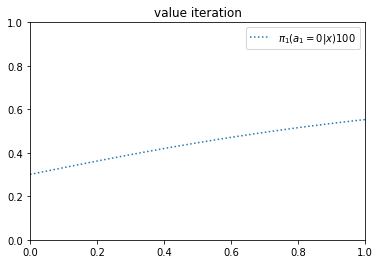

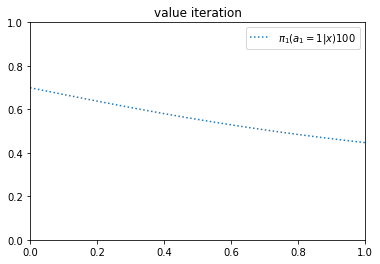

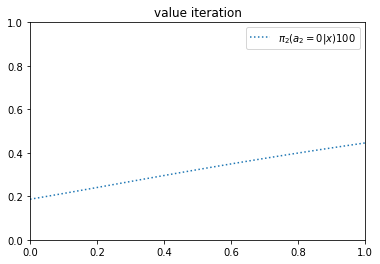

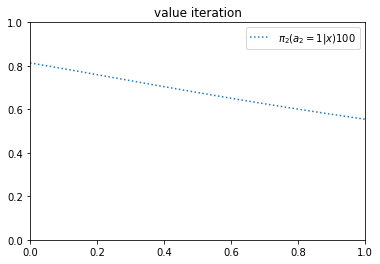

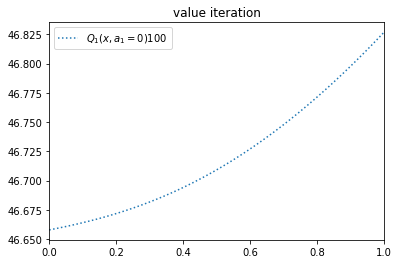

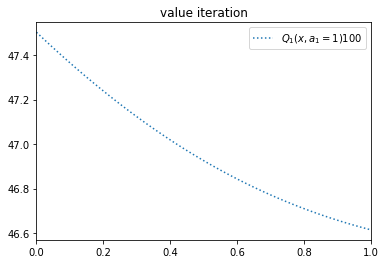

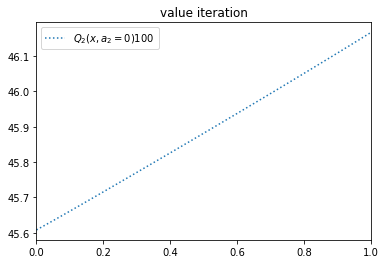

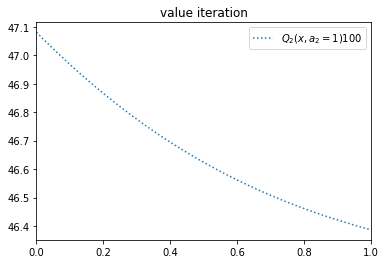

In [50]:
import matplotlib.pyplot as plt
discrete_list = [100]

for i in range(len(discrete_list)):
  xx_plot = np.linspace(0,1,num=discrete_list[i])
  plt.plot(xx_plot,ccp1_tol[i][:,0],':',label = r'$\pi_1(a_1=0|x)$'+'{}'.format(discrete_list[i]))
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.title('value iteration')
plt.show()

for i in range(len(discrete_list)):
  xx_plot = np.linspace(0,1,num=discrete_list[i])
  plt.plot(xx_plot,ccp1_tol[i][:,1],':',label = r'$\pi_1(a_1=1|x)$'+'{}'.format(discrete_list[i]))
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.title('value iteration')
plt.show()
for i in range(len(discrete_list)):
  xx_plot = np.linspace(0,1,num=discrete_list[i])
  plt.plot(xx_plot,ccp2_tol[i][:,0],':',label = r'$\pi_2(a_2=0|x)$'+'{}'.format(discrete_list[i]))
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.title('value iteration')
plt.show()
for i in range(len(discrete_list)):
  xx_plot = np.linspace(0,1,num=discrete_list[i])
  plt.plot(xx_plot,ccp2_tol[i][:,1],':',label = r'$\pi_2(a_2=1|x)$'+'{}'.format(discrete_list[i]))
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.title('value iteration')
plt.show()

for i in range(len(discrete_list)):
  xx_plot = np.linspace(0,1,num=discrete_list[i])
  plt.plot(xx_plot,Qinf1_tol[i][:,0],':',label = r'$Q_1(x,a_1=0)$'+'{}'.format(discrete_list[i]))
plt.xlim(0,1)
#plt.ylim(45,48)
plt.legend()
plt.title('value iteration')
plt.show()
for i in range(len(discrete_list)):
  xx_plot = np.linspace(0,1,num=discrete_list[i])
  plt.plot(xx_plot,Qinf1_tol[i][:,1],':',label = r'$Q_1(x,a_1=1)$'+'{}'.format(discrete_list[i]))
plt.xlim(0,1)
#plt.ylim(45,48)
plt.legend()
plt.title('value iteration')
plt.show()
for i in range(len(discrete_list)):
  xx_plot = np.linspace(0,1,num=discrete_list[i])
  plt.plot(xx_plot,Qinf2_tol[i][:,0],':',label = r'$Q_2(x,a_2=0)$'+'{}'.format(discrete_list[i]))
plt.xlim(0,1)
#plt.ylim(45,48)
plt.legend()
plt.title('value iteration')
plt.show()
for i in range(len(discrete_list)):
  xx_plot = np.linspace(0,1,num=discrete_list[i])
  plt.plot(xx_plot,Qinf2_tol[i][:,1],':',label = r'$Q_2(x,a_2=1)$'+'{}'.format(discrete_list[i]))
plt.xlim(0,1)
#plt.ylim(45,48)
plt.legend()
plt.title('value iteration')
plt.show()

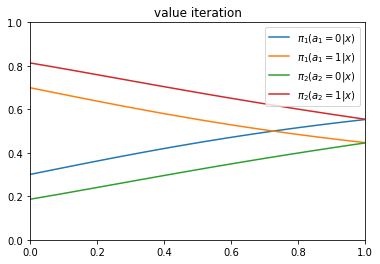

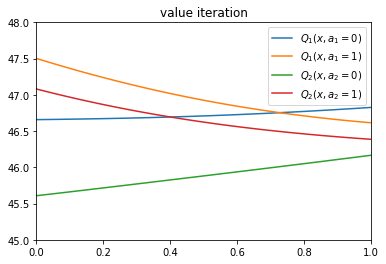

In [51]:
import matplotlib.pyplot as plt
belief_data = 100
xx_plot = np.linspace(0,1,num=belief_data)
plt.plot(xx_plot,ccp1[:,0],'-',label = r'$\pi_1(a_1=0|x)$')
plt.plot(xx_plot,ccp1[:,1],'-',label = r'$\pi_1(a_1=1|x)$')
plt.plot(xx_plot,ccp2[:,0],'-',label = r'$\pi_2(a_2=0|x)$')
plt.plot(xx_plot,ccp2[:,1],'-',label = r'$\pi_2(a_2=1|x)$')
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.title('value iteration')
plt.show()

plt.plot(xx_plot,Qinf1[:,0],'-',label = r'$Q_1(x,a_1=0)$')
plt.plot(xx_plot,Qinf1[:,1],'-',label = r'$Q_1(x,a_1=1)$')
plt.plot(xx_plot,Qinf2[:,0],'-',label = r'$Q_2(x,a_2=0)$')
plt.plot(xx_plot,Qinf2[:,1],'-',label = r'$Q_2(x,a_2=1)$')
plt.xlim(0,1)
plt.ylim(45,48)
plt.legend()
plt.title('value iteration')
plt.show()

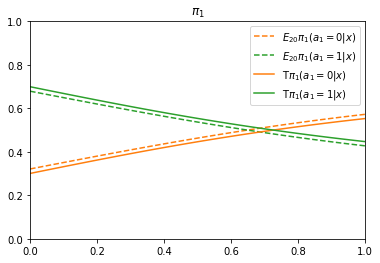

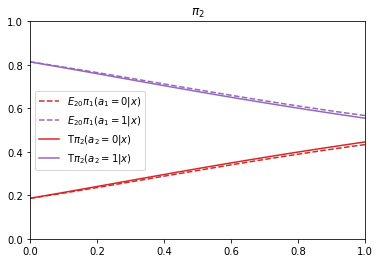

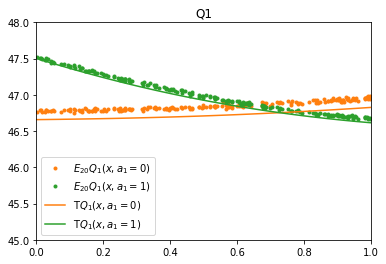

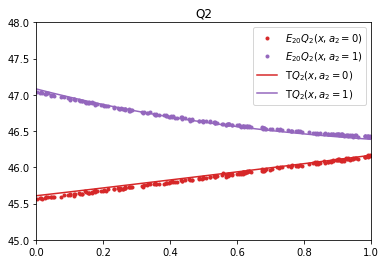

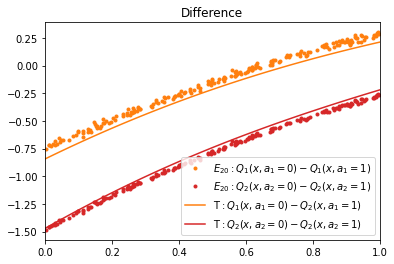

In [59]:
import matplotlib.pyplot as plt
#belief_data = 60
xx_plot = np.linspace(0,1,num=belief_data)
if Q_curvefit:
  plt.plot(xx_plot,fuc1(xx_plot,slop1_Q[epsoide-1,:,:]),'--',label = r'$E_{20}\pi_1(a_1=0|x)$',color = 'C1')
  plt.plot(xx_plot,1-fuc1(xx_plot,slop1_Q[epsoide-1,:,:]),'--',label = r'$E_{20}\pi_1(a_1=1|x)$',color = 'C2')
else:  
  plt.plot(xx_plot,f_1(xx_plot,slop1_pi[epsoide-1,0],slop1_pi[epsoide-1,1],slop1_pi[epsoide-1,2]),'--',label = r'$E_{20}\pi_1(a_1=0|x)$',color = 'C1')
  plt.plot(xx_plot,1-f_1(xx_plot,slop1_pi[epsoide-1,0],slop1_pi[epsoide-1,1],slop1_pi[epsoide-1,2]),'--',label = r'$E_{20}\pi_1(a_1=1|x)$',color = 'C2')
plt.plot(xx_plot,ccp1[:,0],'-',label = r'T$\pi_1(a_1=0|x)$',color = 'C1')
plt.plot(xx_plot,ccp1[:,1],'-',label = r'T$\pi_1(a_1=1|x)$',color = 'C2')
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.title(r'$\pi_1$')
plt.show()

if Q_curvefit:
  plt.plot(xx_plot,fuc2(xx_plot,slop2_Q[epsoide-1,:,:]),'--',label = r'$E_{20}\pi_1(a_1=0|x)$',color = 'C3')
  plt.plot(xx_plot,1-fuc2(xx_plot,slop2_Q[epsoide-1,:,:]),'--',label = r'$E_{20}\pi_1(a_1=1|x)$',color = 'C4')
else: 
  plt.plot(xx_plot,f_1(xx_plot,slop2_pi[epsoide-1,0],slop2_pi[epsoide-1,1],slop2_pi[epsoide-1,2]),'--',label = r'$E_{20}\pi_2(a_2=0|x)$',color = 'C3')
  plt.plot(xx_plot,1-f_1(xx_plot,slop2_pi[epsoide-1,0],slop2_pi[epsoide-1,1],slop2_pi[epsoide-1,2]),'--',label = r'$E_{20}\pi_2(a_2=1|x)$',color = 'C4')
plt.plot(xx_plot,ccp2[:,0],'-',label = r'T$\pi_2(a_2=0|x)$',color = 'C3')
plt.plot(xx_plot,ccp2[:,1],'-',label = r'T$\pi_2(a_2=1|x)$',color = 'C4')

plt.ylim(0,1)
plt.xlim(0,1)
plt.legend()
plt.title(r'$\pi_2$')
plt.show()

plt.plot(xx[epsoide-1,:],Q1[epsoide-1,:,0],'.',label = r'$E_{20}Q_1(x,a_1=0)$',color = 'C1')
plt.plot(xx[epsoide-1,:],Q1[epsoide-1,:,1],'.',label = r'$E_{20}Q_1(x,a_1=1)$',color = 'C2')
plt.plot(xx_plot,Qinf1[:,0],'-',label = r'T$Q_1(x,a_1=0)$',color = 'C1')
plt.plot(xx_plot,Qinf1[:,1],'-',label = r'T$Q_1(x,a_1=1)$',color = 'C2')
plt.xlim(0,1)
plt.ylim(45,48)
plt.legend()
plt.title('Q1')

plt.show()

plt.plot(xx[epsoide-1,:],Q2[epsoide-1,:,0],'.',label = r'$E_{20}Q_2(x,a_2=0)$',color = 'C3')
plt.plot(xx[epsoide-1,:],Q2[epsoide-1,:,1],'.',label = r'$E_{20}Q_2(x,a_2=1)$',color = 'C4')
plt.plot(xx_plot,Qinf2[:,0],'-',label = r'T$Q_2(x,a_2=0)$',color = 'C3')
plt.plot(xx_plot,Qinf2[:,1],'-',label = r'T$Q_2(x,a_2=1)$',color = 'C4')
plt.xlim(0,1)
plt.ylim(45,48)
plt.legend()
plt.title('Q2')

plt.show()

plt.plot(xx[epsoide-1,:],Q1[epsoide-1,:,0]-Q1[epsoide-1,:,1],'.',label = r'$E_{20}:Q_1(x,a_1=0)-Q_1(x,a_1=1)$',color = 'C1')
plt.plot(xx[epsoide-1,:],Q2[epsoide-1,:,0]-Q2[epsoide-1,:,1],'.',label = r'$E_{20}:Q_2(x,a_2=0)-Q_2(x,a_2=1)$',color = 'C3')
plt.plot(xx_plot,Qinf1[:,0]-Qinf1[:,1],'-',label = r'T$:Q_1(x,a_1=0)-Q_2(x,a_1=1)$',color = 'C1')
plt.plot(xx_plot,Qinf2[:,0]-Qinf2[:,1],'-',label = r'T$:Q_2(x,a_2=0)-Q_2(x,a_2=1)$',color = 'C3')
plt.xlim(0,1)
#plt.ylim(45,48)
plt.legend()
plt.title('Difference')

plt.show()



In [49]:
import pandas as pd

np.random.seed(0)
theta2 = np.random.uniform(1,5,8)
#print(theta)
theta2 = np.reshape(pd.Series(theta2).round(2).to_numpy(),[2,2,2])
#print(theta)
N = 1500
T = 30
x0_dim = 50
belief_data = 60
belief_recover = 30
dataset = DataGeneration(theta2,N,T,x0_dim)
res = dataset.simulation(belief_data)
print(res)

AttributeError: ignored

In [ ]:
##############Recover###############
# haha1 = np.ones([blief,2])/2
# PolicyFunc = lambda theta_try : PerfectMarkov(haha1, haha1,theta = theta_try, maxiter = 200,blief = blief)


def LogLike_MLE1(theta1,res=res,dataset=dataset,params=False):
  x0=res['belief'][:,0]
  obz = res['observation']
  ac1 = res['action1']
  ac2 = res['action2']
  #print('Compute Perfect Markov Equlibrium')
  # ccp1,ccp2,_ = PolicyFunc(theta)
  loglike = 0
  blief_x = x0.copy()

  theta1_new = np.reshape(theta1,[2,2,2,2,2])
  #print('Compute Loglike')
  for ss in range(N):
    for t in range(T):

      blief_x[ss],sigma = dataset.siglam(obz[ss,t],blief_x[ss],ac1[ss,t],ac2[ss,t],theta1_new)
      loglike = loglike + np.log(sigma)#np.log(blief_x[ss])
  if params:
    print(-loglike)
  return -loglike

def LogLike_MLE2(theta2,theta1,belief_recover,res=res,dataset=dataset,params=True):
  iniccp_recover = np.ones([belief_recover,2])/2#np.vstack([np.ones(self.blief),np.zeros(self.blief)]).T
  theta2 = np.reshape(theta2,[2,2,2])
  x0=res['belief'][:,0]
  obz = res['observation']
  ac1 = res['action1']
  ac2 = res['action2']
  #print('Compute Perfect Markov Equlibrium')
  loglike = np.zeros(2)
  blief_x = x0.copy()

  theta1_new = np.reshape(theta1,[2,2,2,2,2])

  #for ccp in range(1,2):
  ccp = 1
  ccp1,ccp2,_ = dataset.PerfectMarkov(ccp,iniccp_recover,theta2, theta1_new,belief_recover)
  #print(ccp1,ccp2)
  for ss in range(N):
    for t in range(T):
      fl = int(np.floor(blief_x[ss] * (belief_recover-1)))
      if fl == belief_recover-1:
        pi1 = ccp1[fl,ac1[ss,t]]
        pi2 = ccp2[fl,ac2[ss,t]]
      else: 
        pi1 = ccp1[fl,ac1[ss,t]] * (blief_x[ss] *(belief_recover-1) - fl) + ccp1[fl+1,ac1[ss,t]]* (1 + fl -blief_x[ss] *(belief_recover-1)) 
        pi2 = ccp2[fl,ac2[ss,t]] * (blief_x[ss] *(belief_recover-1) - fl) + ccp2[fl+1,ac2[ss,t]]* (1 + fl -blief_x[ss] *(belief_recover-1))
      loglike[ccp-1] = loglike[ccp-1] + np.log(pi1) + np.log(pi2)

      blief_x[ss],_ = dataset.siglam(obz[ss,t],blief_x[ss],ac1[ss,t],ac2[ss,t],theta1=theta1_new)
  if params:
    print(theta2,-loglike[0])
  return -np.max(loglike[0])


In [ ]:
print(theta2)
print(dataset.dygame)
print(-LogLike_MLE1(dataset.dygame,params=False))
print(-LogLike_MLE2(theta2,dataset.dygame,60,params=True))

[[[3.2  3.86]
  [3.41 3.18]]

 [[2.69 3.58]
  [2.75 4.57]]]
[[[[[0.05       0.45      ]
    [0.4        0.1       ]]

   [[0.5        0.5       ]
    [0.         0.        ]]]


  [[[0.11764706 0.29411765]
    [0.23529412 0.35294118]]

   [[0.25       0.125     ]
    [0.5        0.125     ]]]]



 [[[[0.1875     0.25      ]
    [0.25       0.3125    ]]

   [[0.33333333 0.375     ]
    [0.20833333 0.08333333]]]


  [[[0.27272727 0.09090909]
    [0.63636364 0.        ]]

   [[0.1        0.5       ]
    [0.05       0.35      ]]]]]
-30135.37016792802
[[[3.2  3.86]
  [3.41 3.18]]

 [[2.69 3.58]
  [2.75 4.57]]] 59281.6351320111
-59281.6351320111


In [ ]:

from scipy.optimize import minimize
#bounds = [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]
from scipy.optimize import LinearConstraint

func1 = lambda theta1_dk: LogLike_MLE1(np.array([theta1_dk[0], 1- np.sum(dataset.dygame[0,0,0,1,:])-theta1_dk[0],dataset.dygame[0,0,0,1,0],dataset.dygame[0,0,0,1,1],\
                                                theta1_dk[1], 1- np.sum(dataset.dygame[0,0,1,1,:])-theta1_dk[1],dataset.dygame[0,0,1,1,0],dataset.dygame[0,0,1,1,1],\
                                                theta1_dk[2], 1- np.sum(dataset.dygame[0,1,0,1,:])-theta1_dk[2],dataset.dygame[0,1,0,1,0],dataset.dygame[0,1,0,1,1],\
                                                theta1_dk[3], 1- np.sum(dataset.dygame[0,1,1,1,:])-theta1_dk[3],dataset.dygame[0,1,1,1,0],dataset.dygame[0,1,1,1,1],\
                                                theta1_dk[4], 1- np.sum(dataset.dygame[1,0,0,1,:])-theta1_dk[4],dataset.dygame[1,0,0,1,0],dataset.dygame[1,0,0,1,1],\
                                                theta1_dk[5], 1- np.sum(dataset.dygame[1,0,1,1,:])-theta1_dk[5],dataset.dygame[1,0,1,1,0],dataset.dygame[1,0,1,1,1],\
                                                theta1_dk[6], 1- np.sum(dataset.dygame[1,1,0,1,:])-theta1_dk[6],dataset.dygame[1,1,0,1,0],dataset.dygame[1,1,0,1,1],\
                                                theta1_dk[7], 1- np.sum(dataset.dygame[1,1,1,1,:])-theta1_dk[7],dataset.dygame[1,1,1,1,0],dataset.dygame[1,1,1,1,1]]))

linear_constraint = LinearConstraint([[1,0,0,0,0,0,0,0],\
                                      [0,1,0,0,0,0,0,0],\
                                      [0,0,1,0,0,0,0,0],\
                                      [0,0,0,1,0,0,0,0],\
                                      [0,0,0,0,1,0,0,0],\
                                      [0,0,0,0,0,1,0,0],\
                                      [0,0,0,0,0,0,1,0],\
                                      [0,0,0,0,0,0,0,1]],\
                                     [0,(1- np.sum(dataset.dygame[0,0,1,1,:]))*0,0,(1- np.sum(dataset.dygame[0,1,1,1,:]))*0,0,0,(1- np.sum(dataset.dygame[1,1,0,1,:]))*0,0], \
                                     [(1- np.sum(dataset.dygame[0,0,0,1,:])),1- np.sum(dataset.dygame[0,0,1,1,:]),(1- np.sum(dataset.dygame[0,1,0,1,:])),1- np.sum(dataset.dygame[0,1,1,1,:]),\
                                      (1- np.sum(dataset.dygame[1,0,0,1,:])),(1- np.sum(dataset.dygame[1,0,1,1,:])),1- np.sum(dataset.dygame[1,1,0,1,:]),(1- np.sum(dataset.dygame[1,1,1,1,:]))])          
                                    #  [0,(1- np.sum(dataset.dygame[0,0,1,1,:]))*0,0,(1- np.sum(dataset.dygame[0,1,1,1,:]))*0,0,0,(1- np.sum(dataset.dygame[1,1,0,1,:]))*0,0], \
                                    #  [(1- np.sum(dataset.dygame[0,0,0,1,:])),1- np.sum(dataset.dygame[0,0,1,1,:]),(1- np.sum(dataset.dygame[0,1,0,1,:])),1- np.sum(dataset.dygame[0,1,1,1,:]),\
                                    #   (1- np.sum(dataset.dygame[1,0,0,1,:])),(1- np.sum(dataset.dygame[1,0,1,1,:])),1- np.sum(dataset.dygame[1,1,0,1,:]),(1- np.sum(dataset.dygame[1,1,1,1,:]))])  
# resbrute1 = optimize.brute(LogLike_MLE1, rranges, full_output=True,
#                           finish=optimize.fmin)
x0 = np.array([0.05,0.5,0.11764706,0.25,0.1875 ,0.33333333,0.27272727,0.1])

res = minimize(func1, x0,constraints=[linear_constraint])#,
               #options={'verbose': 3})#, bounds=bounds)
theta1 = np.array([res.x[0], 1- np.sum(dataset.dygame[0,0,0,1,:])-res.x[0],dataset.dygame[0,0,0,1,0],dataset.dygame[0,0,0,1,1],\
                                                res.x[1], 1- np.sum(dataset.dygame[0,0,1,1,:])-res.x[1],dataset.dygame[0,0,1,1,0],dataset.dygame[0,0,1,1,1],\
                                                res.x[2], 1- np.sum(dataset.dygame[0,1,0,1,:])-res.x[2],dataset.dygame[0,1,0,1,0],dataset.dygame[0,1,0,1,1],\
                                                res.x[3], 1- np.sum(dataset.dygame[0,1,1,1,:])-res.x[3],dataset.dygame[0,1,1,1,0],dataset.dygame[0,1,1,1,1],\
                                                res.x[4], 1- np.sum(dataset.dygame[1,0,0,1,:])-res.x[4],dataset.dygame[1,0,0,1,0],dataset.dygame[1,0,0,1,1],\
                                                res.x[5], 1- np.sum(dataset.dygame[1,0,1,1,:])-res.x[5],dataset.dygame[1,0,1,1,0],dataset.dygame[1,0,1,1,1],\
                                                res.x[6], 1- np.sum(dataset.dygame[1,1,0,1,:])-res.x[6],dataset.dygame[1,1,0,1,0],dataset.dygame[1,1,0,1,1],\
                                                res.x[7], 1- np.sum(dataset.dygame[1,1,1,1,:])-res.x[7],dataset.dygame[1,1,1,1,0],dataset.dygame[1,1,1,1,1]])
#Minimize a function over a given range by brute force.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log


In [ ]:
np.round(theta1.reshape([2,2,2,2,2]),5),res.fun

(array([[[[[0.03683, 0.46317],
           [0.4    , 0.1    ]],
 
          [[0.49549, 0.50451],
           [0.     , 0.     ]]],
 
 
         [[[0.12593, 0.28583],
           [0.23529, 0.35294]],
 
          [[0.23972, 0.13528],
           [0.5    , 0.125  ]]]],
 
 
 
        [[[[0.18783, 0.24967],
           [0.25   , 0.3125 ]],
 
          [[0.33003, 0.3783 ],
           [0.20833, 0.08333]]],
 
 
         [[[0.24926, 0.11438],
           [0.63636, 0.     ]],
 
          [[0.11056, 0.48944],
           [0.05   , 0.35   ]]]]]), 30131.22035440302)

In [ ]:
print(dataset.dygame-theta1.reshape([2,2,2,2,2]))

[[[[[ 0.01317406 -0.01317406]
    [ 0.          0.        ]]

   [[ 0.00451338 -0.00451338]
    [ 0.          0.        ]]]


  [[[-0.00828654  0.00828654]
    [ 0.          0.        ]]

   [[ 0.0102848  -0.0102848 ]
    [ 0.          0.        ]]]]



 [[[[-0.00032917  0.00032917]
    [ 0.          0.        ]]

   [[ 0.00330018 -0.00330018]
    [ 0.          0.        ]]]


  [[[ 0.02347088 -0.02347088]
    [ 0.          0.        ]]

   [[-0.01055742  0.01055742]
    [ 0.          0.        ]]]]]


In [ ]:
#from scipy.optimize import brute
rranges = (slice(3, 5, 0.5), slice(3, 5, 0.5))
from scipy import optimize

haha = []
for blief in [40,50,60,70,80]:
    # func = lambda theta2_dk: LogLike_MLE2(np.array([theta2[0,0,0],theta2[0,0,1],theta2[0,1,0],theta2_dk[0],\
    #                                                 theta2[1,0,0],theta2[1,0,1],theta2[1,1,0],theta2_dk[1]]),theta1)
    func = lambda theta2_dk: LogLike_MLE2(np.array([theta2[0,0,0],theta2[0,0,1],theta2[0,1,0],theta2_dk[0],\
                                                    theta2[1,0,0],theta2[1,0,1],theta2[1,1,0],theta2_dk[1]]),theta1.reshape([2,2,2,2,2]),blief)
    # resbrute = optimize.brute(func, rranges, full_output=True,
    #                           finish=optimize.fmin)

    bounds = [[3,5],[3,5]]
    resbrute = minimize(func, [3.18,4.57], method='L-BFGS-B',#'trust-constr', #options={'verbose': 3}, 
                        bounds=bounds)
    haha.append(resbrute)
    print(haha)
    #Minimize a function over a given range by brute force.

[[[3.2  3.86]
  [3.41 3.18]]

 [[2.69 3.58]
  [2.75 4.57]]] 111515.47025618615
[[[3.2        3.86      ]
  [3.41       3.18000001]]

 [[2.69       3.58      ]
  [2.75       4.57      ]]] 111515.47023475826
[[[3.2        3.86      ]
  [3.41       3.18      ]]

 [[2.69       3.58      ]
  [2.75       4.57000001]]] 111515.47021519882
[[[3.2  3.86]
  [3.41 5.  ]]

 [[2.69 3.58]
  [2.75 5.  ]]] 114854.09415280078
[[[3.2        3.86      ]
  [3.41       5.00000001]]

 [[2.69       3.58      ]
  [2.75       5.        ]]] 114854.0942240217
[[[3.2        3.86      ]
  [3.41       5.        ]]

 [[2.69       3.58      ]
  [2.75       5.00000001]]] 114854.09414627694
[[[3.2        3.86      ]
  [3.41       3.75822021]]

 [[2.69       3.58      ]
  [2.75       4.70661247]]] 110567.2803747026
[[[3.2        3.86      ]
  [3.41       3.75822022]]

 [[2.69       3.58      ]
  [2.75       4.70661247]]] 110567.28038168493
[[[3.2        3.86      ]
  [3.41       3.75822021]]

 [[2.69       3.58      ]
  

In [ ]:
resbrute#87

      fun: 55406.79441853568
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00436557, -0.03128662])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 4
   status: 0
  success: True
        x: array([3.15554133, 4.59777192])

In [ ]:
#from scipy.optimize import brute
rranges = (slice(3, 5, 0.5), slice(3, 5, 0.5))
from scipy import optimize

# func = lambda theta2_dk: LogLike_MLE2(np.array([theta2[0,0,0],theta2[0,0,1],theta2[0,1,0],theta2_dk[0],\
#                                                 theta2[1,0,0],theta2[1,0,1],theta2[1,1,0],theta2_dk[1]]),theta1)
func = lambda theta2_dk: LogLike_MLE2(np.array([theta2[0,0,0],theta2[0,0,1],theta2[0,1,0],theta2_dk[0],\
                                                theta2[1,0,0],theta2[1,0,1],theta2[1,1,0],theta2_dk[1]]),dataset.dygame)
# resbrute = optimize.brute(func, rranges, full_output=True,
#                           finish=optimize.fmin)

bounds = [[3,5],[3,5]]
resbrute = minimize(func, [3.18,4.57], method='L-BFGS-B',#'trust-constr', #options={'verbose': 3}, 
                    bounds=bounds)
#Minimize a function over a given range by brute force.

[[[3.2  3.86]
  [3.41 3.18]]

 [[2.69 3.58]
  [2.75 4.57]]] 49282.264812153575


In [ ]:
resbrute#87